<center>
    <img src="pictures/logo_openclassrooms.png" width="200" alt="data scientist logo"  />
    <img src="pictures/logo_data_scientist.png" width="200" alt="data scientist logo"  />
    <strong> Data Scientist </strong>
</center>

# Projet 7: Implémentez un modèle de scoring

## Modeling

### Sommaire

- <a href="#C1">Présentation</a>

    - <a href="#C1.1">Mission</a>

    - <a href="#C1.2">Spécifications du dashboard</a>

- <a href="#C2">Librairies Importation & default settings</a>

- <a href="#C3">Data Loading</a>

- <a href="#C4">Reminder</a>

- <a href="#C5">Score Bank</a>

    - <a href="#C5.1">Bank Strategy</a>

    - <a href="#C5.2">Score Setting</a>

- <a href="#C6">General Functions</a>

- <a href="#C7">Preprocessing</a>

- <a href="#C8">Baseline model - Logistic Regression</a>

- <a href="#C9">The “Imbalanced classification problem"</a>

- <a href="#C10">Models families</a>

    - <a href="#C10.1">Baseline</a>

    - <a href="#C10.2">RandomUnderSampler(undersampling)</a>

    - <a href="#C10.3">SMOTE (Oversampling)</a>

    - <a href="#C10.4">Weights Balanced</a>

    - <a href="#C10.5">Conclusion</a>

- <a href="#C11">Hyperparameters Optimization - Hyperopt</a>

    - <a href="#C11.1">Bank Gain Score</a>

    - <a href="#C11.2">AUC Score</a>

    - <a href="#C11.3">F beta Score</a>

- <a href="#C12">Model Features Importance</a>

- <a href="#C13">SHAP Features Importance</a>

    - <a href="#C13.1">Global Analysis</a>

    - <a href="#C13.2">Local Analysis</a>

   

***
## <a name="C1">Présentation</a>
***

Je suis Data Scientist au sein d'une société financière, nommée **"Prêt à dépenser"**, qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
***
<center>    
    <img src="pictures/pret_logo.png" width="200" alt="Prêt à dépenser"/>    
</center>

***

L’entreprise souhaite mettre en œuvre **un outil de “scoring crédit”** pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer **un algorithme de classification** en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).
De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.
Prêt à dépenser décide donc de développer **un dashboard interactif** pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.

***

### <a name="C1.1">Mission:</a> 

1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
2. Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

***

### <a name="C1.2">Spécifications du dashboard:</a> 


* Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
* Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
* Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.


***
## <a name="C2">Librairies Importation & default settings</a>
***

In [1]:
%load_ext autotime

time: 156 µs (started: 2022-09-24 07:26:31 +02:00)


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap

from IPython.display import display

from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, fbeta_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import NearestNeighbors

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# for tunning the hyperparmeters 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import warnings
warnings.filterwarnings("ignore")

time: 2.25 s (started: 2022-09-24 07:26:31 +02:00)


***
## <a name="C3">Data loading</a>
***

In [3]:
%%time
train_df = pd.read_csv('train_df.csv')

CPU times: user 9.76 s, sys: 3.34 s, total: 13.1 s
Wall time: 13.2 s
time: 13.2 s (started: 2022-09-24 07:26:33 +02:00)


In [4]:
train_df.shape

(307507, 798)

time: 1.99 ms (started: 2022-09-24 07:26:47 +02:00)


In [5]:
test_df = pd.read_csv('test_df.csv')

time: 1.96 s (started: 2022-09-24 07:26:47 +02:00)


In [6]:
test_df.shape

(48744, 798)

time: 1.28 ms (started: 2022-09-24 07:26:48 +02:00)


In [7]:
# I have droped these features because have an inf max value
X = train_df.drop(columns=['TARGET',
                           'SK_ID_CURR', 
                           'index',
                           'PREV_APP_CREDIT_PERC_MAX',
                           'REFUSED_APP_CREDIT_PERC_MAX',
                           'INSTAL_PAYMENT_PERC_MAX'])
y = train_df['TARGET']

print(X.shape, y.shape)

(307507, 792) (307507,)
time: 302 ms (started: 2022-09-24 07:26:49 +02:00)


In [8]:
X_competition = test_df.drop(columns=['TARGET',
                                      'SK_ID_CURR',
                                      'index',
                                      'PREV_APP_CREDIT_PERC_MAX',
                                      'REFUSED_APP_CREDIT_PERC_MAX', 
                                      'INSTAL_PAYMENT_PERC_MAX'])
print (X_competition.shape)

(48744, 792)
time: 43.5 ms (started: 2022-09-24 07:26:49 +02:00)


In [9]:
#test_df.drop(columns=['TARGET', 'index', 'PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 
#                      'INSTAL_PAYMENT_PERC_MAX']).to_csv('df_test_imputed.csv', index=False)

time: 8.42 ms (started: 2022-09-24 07:26:49 +02:00)


***
## <a name="C4">Reminder</a>
***

<center>
        <img src="pictures/confusion_matrix.png" width="600" alt="matrix_confusion"  />
    <strong>confusion matrix</strong>
</center>


***Precision*** is a metric that quantifies the number of correct positive predictions made.

<img src="pictures/precision.png" width="300" alt="precision formula"  />

***Recall*** is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.
<img src="pictures/recall.png" width="350" alt="recall formula"  />


Maximizing **precision** minimizes false positives and maximizing **recall** minimizes false negatives.

***F1-Score*** provides a way to combine both **precision and recall** into a single measure that captures both properties.
<img src="pictures/f1.png" width="350" alt="f1 formula"  />



The **F1-Score** balances the **precision and recall**.

On some problems, we might be interested in an F1-Score with more attention put on precision, such as when false positives are more important to minimize, but false negatives are still important.

On other problems, we might be interested in an F1-Score with more attention put on recall, such as when false negatives are more important to minimize, but false positives are still important.

The solution is the Fbeta-measure
<img src="pictures/f_beta.png" width="330" alt="f_beta formula"  /> <img src="pictures/f_beta_1.png" width="550" alt="f_beta formula"  />



***
## <a name="C5">Score Bank</a>
***

### <a name="C5.1">Bank Strategy</a>

La banque cherche à minimiser sa perte en cherchant les personnes qui ne peuvent pas rembourser leur prêt et lorsque ce but est atteint l'évènement est positif. Le défaut de remboursement sera donc considéré comme l'évènement positif. posifit = 1.


<center>
        <img src="pictures/confusion_matrix_1.png" width="400" alt="matrix_confusion"  />
</center>


* TN (True Negatives) : Le prêt est accordé et le client peut rembourser le prêt.
* TP (True Positives) : Le prêt n'est pas accordé et le client ne peut pas rembourser le prêt.
* FP (False Positive) : Le prêt n'est pas accordé mais le client peut rembourser le prêt.
* FN (False Negative) : Le prêt est accordé mais le client ne peut pas rembourser le prêt.

Une banque cherche à ne pas accorder de prêt à des clients qui ne peuvent pas le rembourser. La banque ne veut pas accorder un prêt à un client qui ne peut pas le rembourser (FN à minimiser). La banque fait un déficit si elle n'accorde pas de prêt à des clients qui peuvent rembourser le prêt (FP à minimiser).



### <a name="C5.2">Score setting</a>

On va créer un score en pondérant les différents cas possibles:

* gain_total = COEF_TN x TN + COEF_FP x FP + COEF_FN x FN + COEF_TP x TP
* gain_max = (TN + FP) x COEF_TN + (TP + FN) x COEF_TP
* gain_min = (TN + FP) x COEF_FP + (TP + FN) x COEF_FN
* score = (gain_total - gain_min) / (gain_max - gain_min)


coefficients données arbitrairements en respectant la métrique métier à valider par retour d'expériences  :

* FN = perte d'argent pour la banque                       ==> COEF_FN = -100
* TP = refus de prêt                                       ==> COEF_TP =  0
* TN = prêt accordé, gain d'argent pour la banque          ==> COEF_TN = +10
* FP = client perdu, moins du gain d'argent pour la banque ==> COEF_FP = -1


***
## <a name="C6">General Functions</a>
***

In [10]:
def matrice_confusion(model, X, y):
    
    """
    this function will return the confusion matrix with the percentages.
    """
    
    # confusion matrix setting.
    df_matrice_confusion = pd.DataFrame(columns=['Predicted Negative (0)','Predicted Positive (1)'], 
                                        index=['Real Negative (0)','Real Positive (1)'])
    
    tn, fp, fn, tp = confusion_matrix(y, model.predict(X)).ravel()
    tot = (tn+fp+fn+tp)


    # Matrix loading.
    df_matrice_confusion['Predicted Negative (0)'] = ["{} ({:2.1%} TN)".format(tn, tn/tot),
                                                      "{} ({:2.1%} FN)".format(fn, fn/tot)]
    df_matrice_confusion['Predicted Positive (1)'] = ["{} ({:2.1%} FP)".format(fp, fp/tot),
                                                      "{} ({:2.1%} TP)".format(tp, tp/tot)]
    
    return df_matrice_confusion

time: 5.14 ms (started: 2022-09-24 07:26:49 +02:00)


In [11]:
def bank_score(y_true, y_pred, coeff_tn=10, coeff_fp=-1, coeff_fn=-100, coeff_tp=0):
    '''
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
               
    total = (coeff_tn*tn + coeff_fp*fp + coeff_fn*fn + coeff_tp*tp)

    #calcul du gain maximal que peut avoir la banque quand il n'y a pas de perte d'argent. C'est à dire que le modèle ne détecte que TN et les TP.
    max_gain = (tn + fp)*coeff_tn + (tp + fn)*coeff_tp

    #calcul du gain minimal (perte) que peut avoir la banque quand il n'y a pas de gain d'argent. C'est à dire que le modèle ne détecte que FN et les FP.
    min_gain = (tn + fp)*coeff_fp + (tp + fn)*coeff_fn

    #normalisation min-max feature scalling : score= (tot-min)/(max-min) https://en.wikipedia.org/wiki/Normalization_(statistics) 
    score = (total - min_gain)/(max_gain - min_gain)

    return score

time: 5.92 ms (started: 2022-09-24 07:26:49 +02:00)


In [12]:
def train_models(model, X_train, X_test, y_train, y_test):
    
    '''this function will return the follow scores: auc, 
       accuracy, f1, precision & recall.'''
    
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test)),
      'Bank': bank_score(y_test, model.predict(X_test))
      }
          
    return output

time: 8.1 ms (started: 2022-09-24 07:26:49 +02:00)


***
## <a name="C7">Preprocessing</a>
***

In [13]:
%%time

# split X & y in train-set and test_set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit on the training data
imputer.fit(X_train)

# Transform training, testing and competition data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)
X_competition = imputer.transform(X_competition)


CPU times: user 15.1 s, sys: 7.08 s, total: 22.2 s
Wall time: 38.9 s
time: 38.9 s (started: 2022-09-24 07:26:49 +02:00)


In [14]:
cols = test_df.drop(columns=['SK_ID_CURR','TARGET',
                      'index',
                      'PREV_APP_CREDIT_PERC_MAX',
                      'REFUSED_APP_CREDIT_PERC_MAX', 
                      'INSTAL_PAYMENT_PERC_MAX']).columns

time: 483 ms (started: 2022-09-24 07:27:28 +02:00)


In [15]:
df_competition = pd.DataFrame(X_competition, columns=cols)

time: 20.6 ms (started: 2022-09-24 07:27:28 +02:00)


In [16]:
df_competition['SK_ID_CURR'] = test_df['SK_ID_CURR']
df_competition.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT,SK_ID_CURR
0,1.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,100001
1,0.0,0.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,100005
2,0.0,1.0,0.0,0.0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,100013
3,1.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,100028
4,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.010032,-13040.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,100038


time: 169 ms (started: 2022-09-24 07:27:28 +02:00)


In [17]:
#df_competition.to_csv('df_competition.csv', index=False)

time: 141 µs (started: 2022-09-24 07:27:28 +02:00)


***
## <a name="C8">Baseline model - Logistic Regression</a>
***

Temps pour l'ensemble des cross validations : 37.17001676559448  s


AUC crossvalidation results :


,Model,Train score,Test_score,Fit_time
0,LogisticRegression,0.768892,0.763212,5.420653


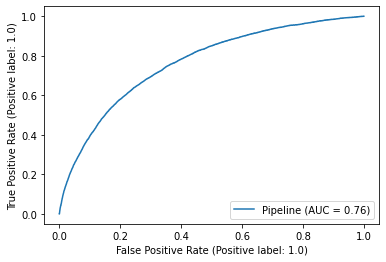



Confusion Matrix


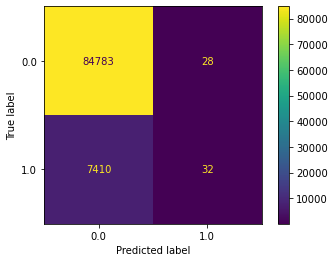

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),84783 (91.9% TN),28 (0.0% FP)
Real Positive (1),7410 (8.0% FN),32 (0.0% TP)


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84811
         1.0       0.53      0.00      0.01      7442

    accuracy                           0.92     92253
   macro avg       0.73      0.50      0.48     92253
weighted avg       0.89      0.92      0.88     92253



time: 46.1 s (started: 2022-09-19 21:51:13 +02:00)


In [19]:
# Make the model with the specified regularization parameter
log_reg = Pipeline([('scaler', StandardScaler()), 
                    ('logistic_regression', LogisticRegression(C = 0.0001, random_state=50))])
# Best Models Cross Validation 
t0 = time.time()

results = []


cv_results = cross_validate(log_reg, X_train, y_train, scoring='roc_auc', cv=5, return_train_score=True,return_estimator=True)
results.append([type(log_reg[1]).__name__, 
                cv_results["train_score"].mean(), 
                cv_results["test_score"].mean(), 
                cv_results["fit_time"].mean()])

print("Temps pour l'ensemble des cross validations :", time.time() - t0, " s")
results = pd.DataFrame(results, columns=['Model','Train score','Test_score','Fit_time'])
print('\n')
print('AUC crossvalidation results :')
display(results)


# Train on the training data
log_reg.fit(X_train, y_train)

plot_roc_curve(log_reg, X_test, y_test, response_method='predict_proba')
plt.show()

print('\n')
print('Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test)
plt.show()

display(matrice_confusion(log_reg, X_test, y_test))
print(classification_report(y_test, log_reg.predict(X_test)))
print('\n')

***
Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (91.9) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1

Il est nécessairet de traiter les déséquilibre de données en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire, trois algorithmes va être testé et voir leur effet sur notre modèle.:
***

***
## <a name="C9">The “Imbalanced classification problem"</a>
***

### Class_weight = 'balanced'

Temps pour l'ensemble des cross validations : 41.68303871154785  s


AUC cross validation results with class weight balanced algorithm :


,Model,Train score,Test_score,Fit_time
0,LogisticRegression,0.776059,0.76825,6.371376


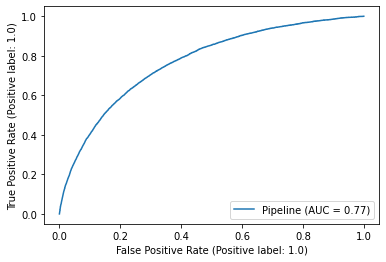



Confusion Matrix


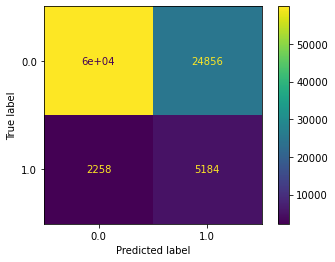

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),59955 (65.0% TN),24856 (26.9% FP)
Real Positive (1),2258 (2.4% FN),5184 (5.6% TP)


              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     84811
         1.0       0.17      0.70      0.28      7442

    accuracy                           0.71     92253
   macro avg       0.57      0.70      0.55     92253
weighted avg       0.90      0.71      0.77     92253



time: 51.8 s (started: 2022-09-19 21:55:12 +02:00)


In [20]:
# Make the model with the specified regularization parameter
log_reg = Pipeline([('scaler', StandardScaler()), 
                    ('logistic_regression', LogisticRegression(C = 0.0001, 
                                                               class_weight='balanced',
                                                               random_state=50))])


# Best Models Cross Validation 
t0 = time.time()

results = []


cv_results = cross_validate(log_reg, X_train, y_train, scoring='roc_auc', cv=5, return_train_score=True,return_estimator=True)
results.append([type(log_reg[1]).__name__, 
                cv_results["train_score"].mean(), 
                cv_results["test_score"].mean(), 
                cv_results["fit_time"].mean()])

print("Temps pour l'ensemble des cross validations :", time.time() - t0, " s")
results = pd.DataFrame(results, columns=['Model','Train score','Test_score','Fit_time'])

print('\n')
print('AUC cross validation results with class weight balanced algorithm :')
display(results)


# Train on the training data
log_reg.fit(X_train, y_train)


plot_roc_curve(log_reg, X_test, y_test, response_method='predict_proba')
plt.show()

print('\n')
print('Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test)
plt.show()

display(matrice_confusion(log_reg, X_test, y_test))
print(classification_report(y_test, log_reg.predict(X_test)))
print('\n')

### RandomUnderSampler (undersampling)

In [21]:
# transform the dataset
undersample = RandomUnderSampler(random_state=50)
X_train_under_sampled, y_train_under_sampled = undersample.fit_resample(X_train, y_train)

# summarize class distribution
print('train_data')
print("Label 1, Before using RandomUnderSampler: {} ".format(sum(y_train==1)))
print("Label 0, Before using RandomUnderSampler: {} ".format(sum(y_train==0)))
print('\n')

# summarize the new class distribution
print("Label 1, After using RandomUnderSampler: {}".format(sum(y_train_under_sampled==1)))
print("Label 0, After using RandomUnderSampler: {}".format(sum(y_train_under_sampled==0)))
print('\n')

train_data
Label 1, Before using RandomUnderSampler: 17383 
Label 0, Before using RandomUnderSampler: 197871 


Label 1, After using RandomUnderSampler: 17383
Label 0, After using RandomUnderSampler: 17383


time: 1.23 s (started: 2022-09-19 21:56:35 +02:00)


Temps pour l'ensemble des cross validations : 4.111987113952637  s
AUC crossvalidation results with undersampler:


,Model,Train score,Test_score,Fit_time
0,LogisticRegression,0.765397,0.755613,0.600854


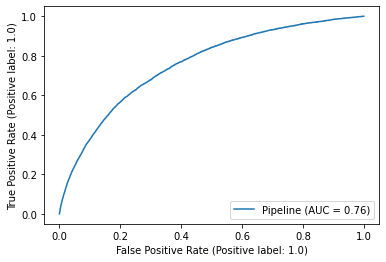



Confusion Matrix


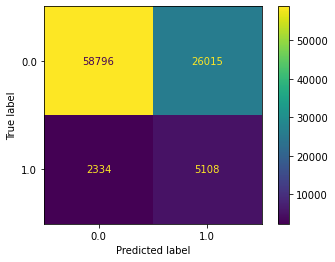

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),58796 (63.7% TN),26015 (28.2% FP)
Real Positive (1),2334 (2.5% FN),5108 (5.5% TP)


              precision    recall  f1-score   support

         0.0       0.96      0.69      0.81     84811
         1.0       0.16      0.69      0.26      7442

    accuracy                           0.69     92253
   macro avg       0.56      0.69      0.54     92253
weighted avg       0.90      0.69      0.76     92253



time: 6.52 s (started: 2022-09-19 21:57:45 +02:00)


In [22]:
# Make the model with the specified regularization parameter
log_reg = Pipeline([('scaler', StandardScaler()), 
                    ('logistic_regression', LogisticRegression(C = 0.0001, random_state=50))])

# Best Models Cross Validation 
t0 = time.time()

results = []


cv_results = cross_validate(log_reg, 
                            X_train_under_sampled, 
                            y_train_under_sampled, 
                            scoring='roc_auc', 
                            cv=5, 
                            return_train_score=True,
                            return_estimator=True)
results.append([type(log_reg[1]).__name__, 
                cv_results["train_score"].mean(), 
                cv_results["test_score"].mean(), 
                cv_results["fit_time"].mean()])

print("Temps pour l'ensemble des cross validations :", time.time() - t0, " s")
results = pd.DataFrame(results, columns=['Model','Train score','Test_score','Fit_time'])

print('AUC crossvalidation results with undersampler:')
display(results)


# Train on the training data
log_reg.fit(X_train_under_sampled, y_train_under_sampled)


plot_roc_curve(log_reg, X_test, y_test, response_method='predict_proba')
plt.show()

print('\n')
print('Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test)
plt.show()

display(matrice_confusion(log_reg, X_test, y_test))
print(classification_report(y_test, log_reg.predict(X_test)))
print('\n')

### SMOTE (Oversampling)

In [23]:
# transform the dataset
oversample = SMOTE(random_state=50)
X_train_over_sampled, y_train_over_sampled = oversample.fit_resample(X_train, y_train)

# summarize class distribution
print('train_data')
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))
print('\n')

# summarize the new class distribution
print("Label 1, After using SMOTE: {}".format(sum(y_train_over_sampled==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_over_sampled==0)))
print('\n')

train_data
Label 1, Before using SMOTE: 17383 
Label 0, Before using SMOTE: 197871 


Label 1, After using SMOTE: 197871
Label 0, After using SMOTE: 197871


time: 15.1 s (started: 2022-09-19 21:58:21 +02:00)


Temps pour l'ensemble des cross validations : 97.27057385444641  s
AUC crossvalidation results with SMOTE oversampler:


,Model,Train score,Test_score,Fit_time
0,LogisticRegression,0.796494,0.795263,15.924683


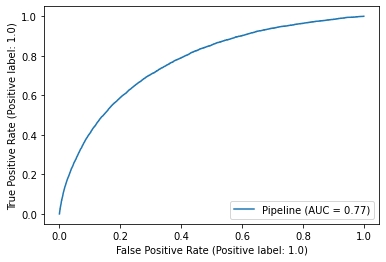



Confusion Matrix


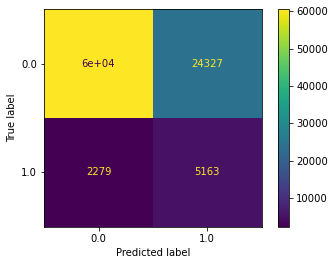

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),60484 (65.6% TN),24327 (26.4% FP)
Real Positive (1),2279 (2.5% FN),5163 (5.6% TP)


              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     84811
         1.0       0.18      0.69      0.28      7442

    accuracy                           0.71     92253
   macro avg       0.57      0.70      0.55     92253
weighted avg       0.90      0.71      0.78     92253



time: 1min 50s (started: 2022-09-19 21:58:50 +02:00)


In [24]:
# Make the model with the specified regularization parameter
log_reg = Pipeline([('scaler', StandardScaler()), 
                    ('logistic_regression', LogisticRegression(C = 0.0001, random_state=50))])

# Best Models Cross Validation 
t0 = time.time()

results = []


cv_results = cross_validate(log_reg, 
                            X_train_over_sampled, 
                            y_train_over_sampled, 
                            scoring='roc_auc', 
                            cv=5, 
                            return_train_score=True,
                            return_estimator=True)
results.append([type(log_reg[1]).__name__, 
                cv_results["train_score"].mean(), 
                cv_results["test_score"].mean(), 
                cv_results["fit_time"].mean()])

print("Temps pour l'ensemble des cross validations :", time.time() - t0, " s")
results = pd.DataFrame(results, columns=['Model','Train score','Test_score','Fit_time'])

print('AUC crossvalidation results with SMOTE oversampler:')
display(results)


# Train on the training data
log_reg.fit(X_train_over_sampled, y_train_over_sampled)


plot_roc_curve(log_reg, X_test, y_test, response_method='predict_proba')
plt.show()

print('\n')
print('Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test)
plt.show()

display(matrice_confusion(log_reg, X_test, y_test))
print(classification_report(y_test, log_reg.predict(X_test)))
print('\n')

***
## <a name="C10">Models families</a>
***

In [25]:
# models setting
models = [Pipeline([('scaler', StandardScaler()), 
                    ('logistic_regression', LogisticRegression(C = 0.0001, random_state=50))]),
          LGBMClassifier(random_state=50),
          XGBClassifier(random_state=50),
          CatBoostClassifier(verbose=0, random_state=50)
         ]

time: 17.1 ms (started: 2022-09-19 22:02:05 +02:00)


### <a name="C10.1">Baseline</a>

In [26]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
bank = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    bank.append(results['Bank'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, bank, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Bank', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)
base_models

CPU times: user 44min 56s, sys: 14.4 s, total: 45min 11s
Wall time: 3min 10s


,Model,AUC,Accuracy,Precision,Recall,F1,Bank,Time
3,CatBoostClassifier,0.785585,0.91997,0.542324,0.050793,0.092886,0.57671,66.937459
1,LGBMClassifier,0.778723,0.919992,0.561368,0.03749,0.070286,0.571469,16.155344
2,XGBClassifier,0.772174,0.918453,0.45954,0.061811,0.108966,0.580143,101.328631
0,Pipeline,0.764636,0.919374,0.533333,0.0043,0.008531,0.557988,6.21748


time: 3min 10s (started: 2022-09-19 22:02:46 +02:00)


### <a name="C10.2">RandomUnderSampler (undersampling)</a>

In [27]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
bank = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_under_sampled, X_test, y_train_under_sampled, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    bank.append(results['Bank'])
    time_.append(time.time()-start)

#Initialise data of lists
under_sampled_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, bank, time_]).T
under_sampled_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Bank', 'Time']
under_sampled_models.sort_values('AUC', ascending=False, inplace=True)
under_sampled_models

CPU times: user 11min 35s, sys: 5.93 s, total: 11min 41s
Wall time: 52.7 s


,Model,AUC,Accuracy,Precision,Recall,F1,Bank,Time
3,CatBoostClassifier,0.781228,0.713559,0.178723,0.709487,0.285521,0.711951,29.948282
1,LGBMClassifier,0.774979,0.706698,0.173893,0.702768,0.2788,0.705146,3.987377
2,XGBClassifier,0.762762,0.69795,0.168232,0.695781,0.270951,0.697093,15.776161
0,Pipeline,0.756059,0.692704,0.164123,0.686375,0.264903,0.690204,3.005446


time: 52.7 s (started: 2022-09-19 22:06:31 +02:00)


### <a name="C10.3">SMOTE (Oversampling)</a>

In [28]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
bank = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_over_sampled, X_test, y_train_over_sampled, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    bank.append(results['Bank'])
    time_.append(time.time()-start)

#Initialise data of lists
over_sampled_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, bank, time_]).T
over_sampled_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Bank', 'Time']
over_sampled_models.sort_values('AUC', ascending=False, inplace=True)
over_sampled_models

CPU times: user 1h 47min 41s, sys: 18.2 s, total: 1h 47min 59s
Wall time: 8min 9s


,Model,AUC,Accuracy,Precision,Recall,F1,Bank,Time
3,CatBoostClassifier,0.781579,0.919634,0.518182,0.053615,0.097175,0.577621,183.482467
1,LGBMClassifier,0.774865,0.920013,0.599369,0.025531,0.048975,0.566759,28.975264
2,XGBClassifier,0.773029,0.919005,0.483766,0.060064,0.106861,0.579788,263.053134
0,Pipeline,0.770294,0.711597,0.175076,0.693765,0.279595,0.704555,13.975358


time: 8min 9s (started: 2022-09-19 22:08:05 +02:00)


### <a name="C10.4">Weights Balanced</a>

In [29]:
# models setting


models_weighted = [Pipeline([('scaler', StandardScaler()), 
                    ('logistic_regression', LogisticRegression(C = 0.0001, 
                                                               class_weight='balanced',
                                                               random_state=50))]),
                   LGBMClassifier(class_weight='balanced', random_state=50),
                   XGBClassifier(scale_pos_weight=99, random_state=50),
                   CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=50)
                  ]

time: 2.37 ms (started: 2022-09-19 22:16:46 +02:00)


In [33]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
bank = []
time_ = []

for model in models_weighted:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    bank.append(results['Bank'])
    time_.append(time.time()-start)

#Initialise data of lists
weighted_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, bank, time_]).T
weighted_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Bank', 'Time']
weighted_models.sort_values('AUC', ascending=False, inplace=True)
weighted_models

CPU times: user 48min 36s, sys: 16.9 s, total: 48min 53s
Wall time: 3min 22s


,Model,AUC,Accuracy,Precision,Recall,F1,Bank,Time
1,LGBMClassifier,0.781075,0.730535,0.184509,0.684359,0.290655,0.712299,12.945547
3,CatBoostClassifier,0.777966,0.787075,0.212904,0.607901,0.31536,0.716314,77.962203
0,Pipeline,0.769678,0.706091,0.17257,0.696587,0.276613,0.702338,9.311882
2,XGBClassifier,0.724093,0.378275,0.103958,0.880274,0.185955,0.576527,101.991824


time: 3min 22s (started: 2022-09-19 22:35:23 +02:00)


### <a name="C10.5">Conclusion :</a>

le modèle LgbmClassifier avec une correction **balanced class weight** a donnée les meilleurs scores AUC **0.781** pour un temps plutot faible **12.9** nous considérons ce modèle

***
## <a name="C11">Hyperparameters Optimization - Hyperopt</a>
***

### <a name="C11.1">Bank gain score</a>

In [34]:
#Parameter space: possible values of parameters
space = {'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
         'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
         'max_depth': hp.quniform('max_depth', 3, 15, 2),
         'subsample': hp.uniform('subsample', 0.60, 0.95),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20),
         'reg_alpha': hp.uniform('reg_alpha', 1, 20),
         'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
        }

time: 6.69 ms (started: 2022-09-19 22:43:54 +02:00)


In [35]:
def objective(params, eval_metric=bank_score):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params_model = {'n_estimators': int(params['n_estimators']),
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_lambda': params['reg_lambda'],
              'reg_alpha': params['reg_alpha'],
              'class_weight':'balanced'
             }
  
    # setting model parameters
    model= LGBMClassifier(**params_model)

    # Seuil de solvabilité
    threshold = params['solvability_threshold']

    # Cross-validation à 5 passes : retourne le score de probabilité
    cv = StratifiedKFold(5)

    y_proba = cross_val_predict(model, X_train, y_train, method='predict_proba', cv=cv)[:, 1]

    # Si proba > seuil alors la prédiction est positive : 1
    y_pred = (y_proba > threshold)
    y_pred = np.array(y_pred > 0) * 1
        
    # Calcul du score suivant la métrique utilisé
    score = eval_metric(y_train, y_pred)
        

    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

time: 1.45 ms (started: 2022-09-19 22:43:54 +02:00)


In [36]:
best_bank_score = fmin(fn=objective, space=space, max_evals=50, algo=tpe.suggest)

100%|██████████| 50/50 [2:11:56<00:00, 158.33s/trial, best loss: 0.28211278963524056]  
time: 2h 11min 56s (started: 2022-09-19 22:43:54 +02:00)


In [37]:
print("Best hyperparameters for bank score: {}".format(best_bank_score))

Best hyperparameters for bank score: {'colsample_bytree': 0.8129702677750317, 'learning_rate': 0.019030099967409793, 'max_depth': 10.0, 'n_estimators': 600.0, 'reg_alpha': 16.874753106519194, 'reg_lambda': 10.157209837961933, 'solvability_threshold': 0.525, 'subsample': 0.7208897339871151}
time: 341 µs (started: 2022-09-20 00:55:51 +02:00)


In [38]:
#Fit a new model based on the best parameters
lgbm_bank_score = LGBMClassifier(n_estimators=int(best_bank_score['n_estimators']),
                                colsample_bytree= best_bank_score['colsample_bytree'],
                                learning_rate= best_bank_score['learning_rate'],
                                max_depth= int(best_bank_score['max_depth']),
                                subsample= best_bank_score['subsample'],
                                reg_lambda= best_bank_score['reg_lambda'],
                                reg_alpha= best_bank_score['reg_alpha'],
                                class_weight='balanced')

lgbm_bank_score.fit(X_train, y_train)
pickle.dump(lgbm_bank_score, open("LGBMClassifier_bank_score.pkl", "wb"))

time: 42.7 s (started: 2022-09-20 00:55:51 +02:00)


#### Evolution du gain en fonction du seuil de solvabilité

In [39]:
def gain_seuil(clf, y_set, x_set, eval_metric=bank_score):
    
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 20)
    
    for threshold in threshold_x:
        
        # Score du modèle : 0 à 1
        y_scores = clf.predict_proba(x_set)[:, 1]
        
        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_scores > threshold)
        
        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(eval_metric(y_set, y_pred))
        
    # Affichage du gain en fonction du seuil de solvabilité    
    plt.plot(threshold_x, cost_function)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))

time: 3.74 ms (started: 2022-09-20 00:56:33 +02:00)


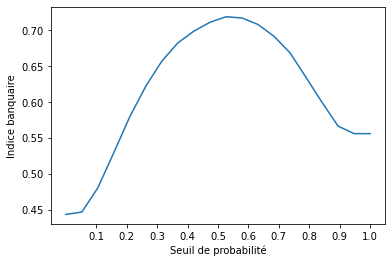

time: 14.5 s (started: 2022-09-20 00:56:33 +02:00)


In [40]:
# Affiche le meilleur seuil de probabilité
gain_seuil(lgbm_bank_score, y_test, X_test)

### <a name="C11.2">AUC score</a>

In [41]:
#Parameter space: possible values of parameters
space = {'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
         'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
         'max_depth': hp.quniform('max_depth', 3, 15, 2),
         'subsample': hp.uniform('subsample', 0.60, 0.95),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20),
         'reg_alpha': hp.uniform('reg_alpha', 1, 20),
         'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
        }

time: 601 µs (started: 2022-09-20 00:56:48 +02:00)


In [42]:
def objective_1(params, eval_metric=roc_auc_score):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params_model = {'n_estimators': int(params['n_estimators']),
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_lambda': params['reg_lambda'],
              'reg_alpha': params['reg_alpha'],
              'class_weight':'balanced'
             }
  
    # setting model parameters
    model= LGBMClassifier(**params_model)

    # Seuil de solvabilité
    threshold = params['solvability_threshold']

    # Cross-validation à 5 passes : retourne le score de probabilité
    cv = StratifiedKFold(5)

    y_proba = cross_val_predict(model, X_train, y_train, method='predict_proba', cv=cv)[:, 1]

    # Si proba > seuil alors la prédiction est positive : 1
    y_pred = (y_proba > threshold)
    y_pred = np.array(y_pred > 0) * 1
        
    # Calcul du score suivant la métrique utilisé
    score = eval_metric(y_train, y_pred)
        

    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

time: 712 µs (started: 2022-09-20 00:56:48 +02:00)


In [43]:
best_auc_score = fmin(fn=objective_1, space=space, max_evals=50, algo=tpe.suggest)

100%|██████████| 50/50 [2:23:46<00:00, 172.53s/trial, best loss: 0.28329969493561324]  
time: 2h 23min 46s (started: 2022-09-20 00:56:48 +02:00)


In [44]:
print("Best AUC Score parameters: {}".format(best_auc_score))

Best AUC Score parameters: {'colsample_bytree': 0.7930753155661002, 'learning_rate': 0.02216702596418517, 'max_depth': 14.0, 'n_estimators': 800.0, 'reg_alpha': 12.559318495324023, 'reg_lambda': 7.314447939558917, 'solvability_threshold': 0.45, 'subsample': 0.7125557195511957}
time: 491 µs (started: 2022-09-20 03:20:34 +02:00)


In [45]:
#Fit a new model based on the best parameters
lgbm_auc_score = LGBMClassifier(n_estimators=int(best_auc_score['n_estimators']),
                                colsample_bytree= best_auc_score['colsample_bytree'],
                                learning_rate= best_auc_score['learning_rate'],
                                max_depth= int(best_auc_score['max_depth']),
                                subsample= best_auc_score['subsample'],
                                reg_lambda= best_auc_score['reg_lambda'],
                                reg_alpha= best_auc_score['reg_alpha'],
                                class_weight='balanced')

lgbm_auc_score.fit(X_train, y_train)
pickle.dump(lgbm_auc_score, open("LGBMClassifier_auc_score.pkl", "wb"))

time: 51.7 s (started: 2022-09-20 03:20:34 +02:00)


### <a name="C11.3">F beta score</a>

In [46]:
#Parameter space: possible values of parameters
space = {'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
         'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
         'max_depth': hp.quniform('max_depth', 3, 15, 2),
         'subsample': hp.uniform('subsample', 0.60, 0.95),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20),
         'reg_alpha': hp.uniform('reg_alpha', 1, 20),
         'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
        }

time: 929 µs (started: 2022-09-20 03:21:26 +02:00)


In [47]:
def objective_2(params):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params_model = {'n_estimators': int(params['n_estimators']),
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_lambda': params['reg_lambda'],
              'reg_alpha': params['reg_alpha'],
              'class_weight':'balanced'
             }
  
    # setting model parameters
    model= LGBMClassifier(**params_model)

    # Seuil de solvabilité
    threshold = params['solvability_threshold']

    # Cross-validation à 5 passes : retourne le score de probabilité
    cv = StratifiedKFold(5)

    y_proba = cross_val_predict(model, X_train, y_train, method='predict_proba', cv=cv)[:, 1]

    # Si proba > seuil alors la prédiction est positive : 1
    y_pred = (y_proba > threshold)
    y_pred = np.array(y_pred > 0) * 1
        
    # Calcul du score suivant la métrique utilisé
    score = fbeta_score(y_train, y_pred,beta=3)
        

    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

time: 1.06 ms (started: 2022-09-20 03:21:26 +02:00)


In [48]:
best_fbeta_score = fmin(fn=objective_2, space=space, max_evals=50, algo=tpe.suggest)

100%|██████████| 50/50 [2:09:53<00:00, 155.87s/trial, best loss: 0.4327213827289118]  
time: 2h 9min 53s (started: 2022-09-20 03:21:26 +02:00)


In [49]:
print("Best F-beta Score parameters: {}".format(best_fbeta_score))

Best F-beta Score parameters: {'colsample_bytree': 0.6056567229899741, 'learning_rate': 0.02413004767722374, 'max_depth': 12.0, 'n_estimators': 900.0, 'reg_alpha': 8.621952805217964, 'reg_lambda': 14.795864282765956, 'solvability_threshold': 0.375, 'subsample': 0.6503970759818074}
time: 442 µs (started: 2022-09-20 05:31:19 +02:00)


In [50]:
#Fit a new model based on the best parameters
lgbm_fbeta_score = LGBMClassifier(n_estimators=int(best_fbeta_score['n_estimators']),
                                colsample_bytree= best_fbeta_score['colsample_bytree'],
                                learning_rate= best_fbeta_score['learning_rate'],
                                max_depth= int(best_fbeta_score['max_depth']),
                                subsample= best_fbeta_score['subsample'],
                                reg_lambda= best_fbeta_score['reg_lambda'],
                                reg_alpha= best_fbeta_score['reg_alpha'],
                                class_weight='balanced')

lgbm_fbeta_score.fit(X_train, y_train)
pickle.dump(lgbm_fbeta_score, open("LGBMClassifier_fbeta_score.pkl", "wb"))

time: 48 s (started: 2022-09-20 05:31:19 +02:00)


#### Prédiction sur les données de validation pour le modèle optimisé avec la métrique gain bank

In [51]:
y_proba_0 = lgbm_bank_score.predict_proba(X_test)[:, 1]
y_pred_0 = (y_proba_0 > best_bank_score['solvability_threshold'])
y_pred_0 = np.array(y_pred_0 > 0) * 1

time: 881 ms (started: 2022-09-20 05:32:07 +02:00)


#### Prédiction sur les données de validation pour le modèle optimisé avec la métrique AUC_score

In [52]:
y_proba_1 = lgbm_auc_score.predict_proba(X_test)[:, 1]
y_pred_1 = (y_proba_1 > best_auc_score['solvability_threshold'])
y_pred_1 = np.array(y_pred_1 > 0) * 1

time: 948 ms (started: 2022-09-20 05:32:08 +02:00)


#### Prédiction sur les données de validation pour le modèle optimisé avec la métrique Fbeta_score

In [53]:
y_proba_2 = lgbm_fbeta_score.predict_proba(X_test)[:, 1]
y_pred_2 = (y_proba_2 > best_fbeta_score['solvability_threshold'])
y_pred_2 = np.array(y_pred_2 > 0) * 1

time: 1.05 s (started: 2022-09-20 05:32:09 +02:00)


Confusion Matrix for bank score:


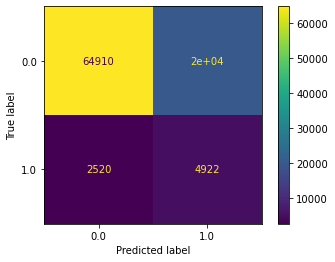



Confusion Matrix for AUC score:


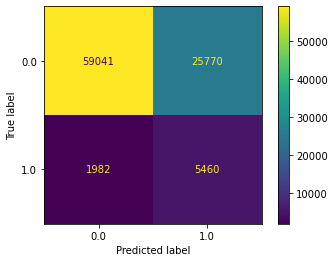



Confusion Matrix for F-beta score:


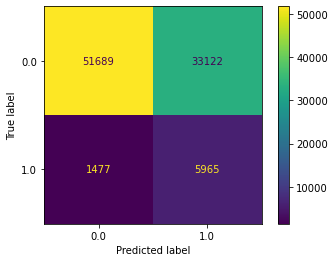

time: 393 ms (started: 2022-09-20 05:32:10 +02:00)


In [54]:
print('Confusion Matrix for bank score:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_0)
plt.show()

print('\n')
print('Confusion Matrix for AUC score:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1)
plt.show()

print('\n')
print('Confusion Matrix for F-beta score:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2)
plt.show()

***
## <a name="C12">Model Features Importance</a>
***

In [55]:
def feature_importance_plot(model=lgbm_bank_score):
    feats = X.columns
    feature_importance_df=pd.DataFrame()
    feature_importance_df["feature"] = feats
    feature_importance_df["importance"] = model.feature_importances_

     # Sort features according to importance
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index()

        # Normalize the feature importances to add up to one
    feature_importance_df['importance_normalized'] = feature_importance_df['importance'] / feature_importance_df['importance'].sum()

        # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (8, 4))
    ax = plt.subplot()

        # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(feature_importance_df.index[:10]))), 
                feature_importance_df['importance_normalized'].head(10), 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
    ax.set_yticks(list(reversed(list(feature_importance_df.index[:10]))))
    ax.set_yticklabels(feature_importance_df['feature'].head(10))

        # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    return plt.show()

time: 826 µs (started: 2022-09-20 05:32:11 +02:00)


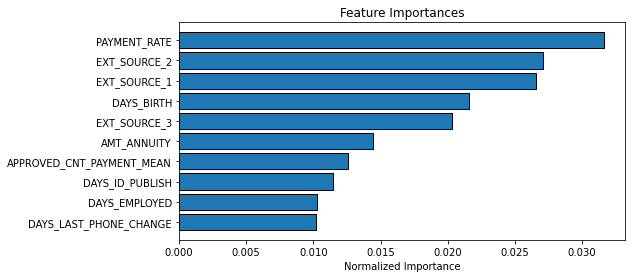

time: 91.8 ms (started: 2022-09-20 05:32:11 +02:00)


In [56]:
feature_importance_plot(lgbm_auc_score)

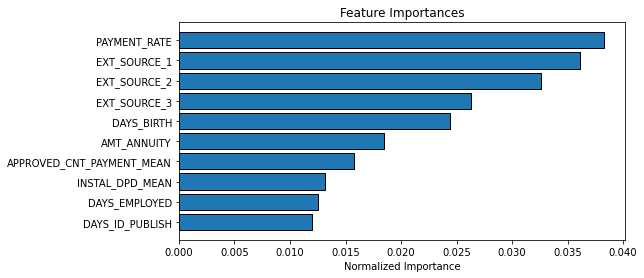

time: 83.8 ms (started: 2022-09-20 05:32:11 +02:00)


In [57]:
feature_importance_plot(lgbm_bank_score)

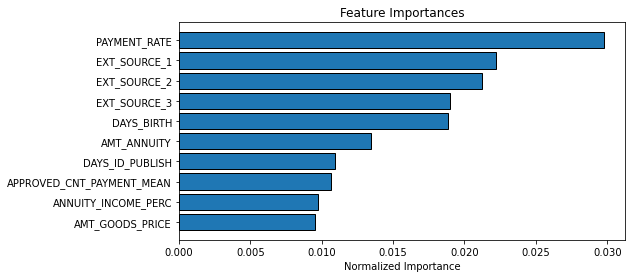

time: 123 ms (started: 2022-09-20 05:54:34 +02:00)


In [73]:
feature_importance_plot(lgbm_fbeta_score)

***
## <a name="C13">SHAP Features Importance</a>
***

In [58]:
# print the JS visualization code to the notebook
shap.initjs()

time: 6.7 ms (started: 2022-09-20 05:32:11 +02:00)


In [59]:
X_shap=pd.DataFrame(X_test)
X_shap.columns = X.columns

time: 387 µs (started: 2022-09-20 05:32:11 +02:00)


In [60]:
explainer = shap.TreeExplainer(lgbm_bank_score)
shap_values = explainer.shap_values(X_shap)[0]
exp_value=explainer.expected_value[0]

time: 54.3 s (started: 2022-09-20 05:32:11 +02:00)


### <a name="C13.1">Global Analysis</a>

In [61]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_shap.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.col_name.head(10).tolist()

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'AMT_ANNUITY',
 'INSTAL_DPD_MEAN',
 'DAYS_EMPLOYED',
 'APPROVED_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Higher education']

time: 160 ms (started: 2022-09-20 05:33:05 +02:00)


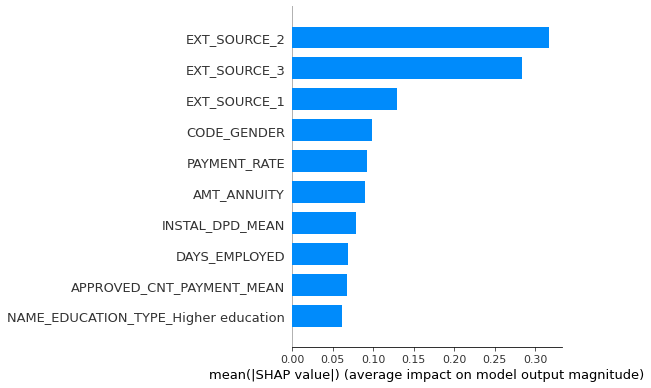

time: 398 ms (started: 2022-09-20 05:33:05 +02:00)


In [62]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=10 )

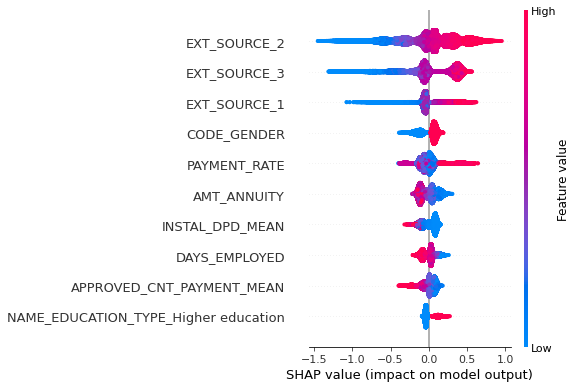

time: 3.81 s (started: 2022-09-20 05:33:06 +02:00)


In [63]:
shap.summary_plot(shap_values,  X_shap.astype("float"), max_display=10)

### <a name="C13.2">Local Analysis</a>

In [64]:
#force_plot
shap.force_plot(exp_value, shap_values[0], features = X_shap.iloc[0], figsize=(12,5))


time: 4.74 ms (started: 2022-09-20 05:33:09 +02:00)


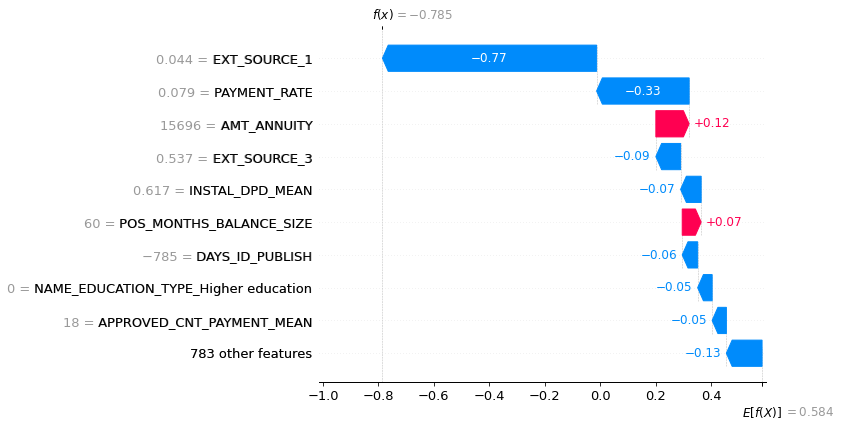

time: 340 ms (started: 2022-09-20 05:33:10 +02:00)


In [65]:
#waterfall_plot
shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
base_values=exp_value, data=X_shap.iloc[0]))


# FIN

## export data for dashboard

In [14]:
#train_df.head()

time: 3.78 ms (started: 2022-09-22 21:28:56 +02:00)


In [15]:
#test_df.head()

time: 11.3 ms (started: 2022-09-22 21:28:56 +02:00)


In [16]:
#total_df = pd.concat([train_df, test_df])

time: 7.93 ms (started: 2022-09-22 21:28:56 +02:00)


In [17]:
#total_df.drop(columns=['index', 'TARGET','PREV_APP_CREDIT_PERC_MAX',
#                           'REFUSED_APP_CREDIT_PERC_MAX',
#                           'INSTAL_PAYMENT_PERC_MAX'], inplace=True)

time: 4.61 ms (started: 2022-09-22 21:28:56 +02:00)


In [18]:
X_dashboard = pd.DataFrame(X_competition, columns=X.columns)
X_dashboard['SK_ID_CURR'] = test_df['SK_ID_CURR']
X_dashboard

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT,SK_ID_CURR
0,1.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,100001
1,0.0,0.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,100005
2,0.0,1.0,0.0,0.0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,100013
3,1.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,100028
4,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,0.010032,-13040.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,100038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,1.0,0.0,0.0,0.0,121500.0,412560.0,17473.5,270000.0,0.002042,-19970.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,456221
48740,1.0,0.0,1.0,2.0,157500.0,622413.0,31909.5,495000.0,0.035792,-11186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,456222
48741,1.0,1.0,0.0,1.0,202500.0,315000.0,33205.5,315000.0,0.026392,-15922.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,456223
48742,0.0,0.0,1.0,0.0,225000.0,450000.0,25128.0,450000.0,0.018850,-13968.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,456224


time: 54 ms (started: 2022-09-24 07:31:20 +02:00)


In [20]:
X_dashboard.sample(frac=0.5, random_state=50).shape

(24372, 793)

time: 97.6 ms (started: 2022-09-24 07:35:32 +02:00)


In [21]:
X_dashboard.to_csv('X_dashboard_0.csv', index=False)

time: 11.1 s (started: 2022-09-24 07:35:32 +02:00)


In [22]:
X_dashboard.sample(frac=0.5, random_state=50).to_csv('X_dashboard_1.csv', index=False)

time: 5.79 s (started: 2022-09-24 07:35:43 +02:00)


In [23]:
X_dashboard.sample(frac=0.05, random_state=50).to_csv('X_dashboard.csv', index=False)


time: 532 ms (started: 2022-09-24 07:35:49 +02:00)


In [25]:
X_dashboard.sample(frac=0.05, random_state=50).head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT,SK_ID_CURR
34892,0.0,0.0,0.0,2.0,180000.0,601470.0,30838.5,450000.0,0.022625,-15753.0,...,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,21.0,355105
44520,0.0,0.0,0.0,0.0,157500.0,509400.0,37197.0,450000.0,0.018850,-23202.0,...,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,21.0,425400
29440,1.0,0.0,1.0,0.0,157500.0,622413.0,33894.0,495000.0,0.024610,-16574.0,...,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,11.0,314366
9467,1.0,0.0,0.0,1.0,315000.0,503266.5,52978.5,463500.0,0.046220,-24401.0,...,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,21.0,168959
40257,1.0,0.0,0.0,0.0,45900.0,71919.0,4396.5,59377.5,0.031329,-21570.0,...,0.125,1.0,0.125,0.0,0.0,0.0,0.0,0.0,8.0,396437


time: 64.3 ms (started: 2022-09-25 08:03:25 +02:00)
